## Import Dependencies

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import os
from glob import glob
import pylandstats as pls
import warnings
import rasterio as rio
import rasterio.mask
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterstats import zonal_stats
import argparse
from tqdm import tqdm
import json
from shapely.geometry import Point
from datetime import datetime, timedelta
from scipy.stats import weibull_min
import concurrent.futures
from concurrent.futures import ProcessPoolExecutor

# Suppress warnings to keep output clean
warnings.filterwarnings('ignore')

## Define File and Directory Paths

In [26]:
# Main directory containing raw raster and vector datasets
MAIN_DATA_DIR = '/beegfs/halder/DATA'

# GitHub-linked project directory where processed data and results are stored
PROJECT_DATA_DIR = '/beegfs/halder/GITHUB/Landscape-Analysis/data'

# Define the DWD data directory
DWD_DATA_DIR = '/beegfs/common/data/climate/dwd/csvs/germany_ubn_1951-01-01_to_2024-08-30'

# Temporary directory used for storing intermediate files
TEMP_DIR = os.path.join(PROJECT_DATA_DIR, 'TEMP')

## Load Hexagonal Grid for Germany

In [27]:
DISTANCE = 2.5
EPSG = 25832  # Use ETRS89 / UTM Zone 32N as the projection (suitable for Germany)

# Path to grid shapefile
GRID_PATH = os.path.join(PROJECT_DATA_DIR, 'VECTOR', f'DE_Hexbins_{DISTANCE}sqkm_EPSG_{EPSG}.shp')

# Define the out directory
OUT_DIR = os.path.join(PROJECT_DATA_DIR, 'OUTPUT', f'Landscape_Metrics_{DISTANCE}KM', 'Climate')

# Load grid as a GeoDataFrame and retain relevant columns
grids_gdf = gpd.read_file(GRID_PATH)
grids_gdf = grids_gdf[['id', 'geometry']]
grids_gdf['id'] = grids_gdf['id'].astype(int)

print('Successfully read the grids!')

Successfully read the grids!


In [28]:
# Read the Germany shapefile
DE_gdf = gpd.read_file(os.path.join(MAIN_DATA_DIR, 'DE_NUTS', 'DE_NUTS_3.shp'))
DE_gdf = DE_gdf[DE_gdf['LEVL_CODE']==1] 
DE_gdf = DE_gdf.to_crs(f'EPSG:{EPSG}')

print(DE_gdf.shape)
DE_gdf.head()

(16, 6)


,NUTS_ID,LEVL_CODE,CNTR_CODE,NAME_LATN,NUTS_NAME,geometry
438,DEF,1,DE,Schleswig-Holstein,Schleswig-Holstein,"MULTIPOLYGON (((647136.269 6037210.901, 647954..."
439,DE8,1,DE,Mecklenburg-Vorpommern,Mecklenburg-Vorpommern,"MULTIPOLYGON (((746439.633 6039257.434, 749642..."
440,DEG,1,DE,Thüringen,Thüringen,"POLYGON ((623559.162 5722734.464, 624893.036 5..."
441,DE9,1,DE,Niedersachsen,Niedersachsen,"MULTIPOLYGON (((479225.624 5970766.611, 479712..."
442,DE1,1,DE,Baden-Württemberg,Baden-Württemberg,"MULTIPOLYGON (((546793.49 5514433.543, 546531...."


In [29]:
grids_centroids = grids_gdf.copy()
grids_centroids['geometry'] = grids_gdf.centroid

grids_centroids = gpd.sjoin_nearest(left_df=grids_centroids, right_df=DE_gdf[['NUTS_NAME', 'geometry']],
                                    how='inner')

grids_gdf = pd.merge(left=grids_gdf, right=grids_centroids[['id', 'NUTS_NAME']], how='inner', on='id')
print(grids_gdf.shape)
grids_gdf.head()

(67545, 3)


,id,geometry,NUTS_NAME
0,68921,"POLYGON ((709129.96 5565059.119, 709851.648 55...",Bayern
1,68920,"POLYGON ((709129.96 5567559.119, 709851.648 55...",Bayern
2,68923,"POLYGON ((709129.96 5560059.119, 709851.648 55...",Bayern
3,68922,"POLYGON ((709129.96 5562559.119, 709851.648 55...",Bayern
4,68925,"POLYGON ((709129.96 5555059.119, 709851.648 55...",Bayern


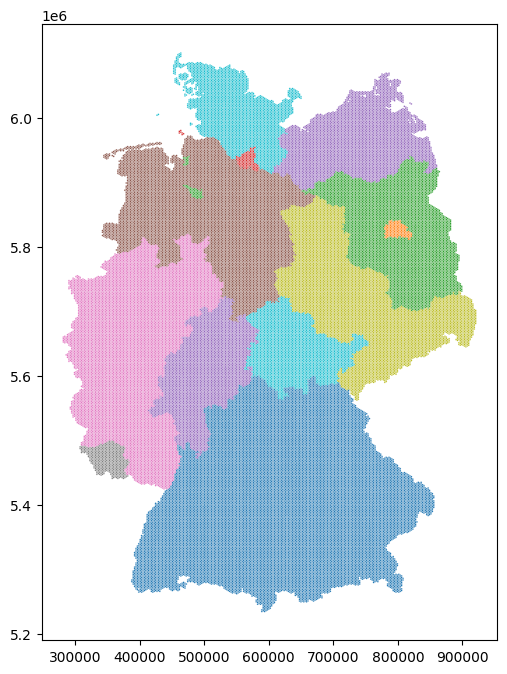

In [30]:
grids_gdf.plot(column='NUTS_NAME', edgecolor='w', linewidth=0.15, figsize=(8, 8));

## Assign the Row and Column ID for Each Hexagon

In [31]:
# Specify the DE DWD grip file path
DE_DWD_json_path = os.path.join(MAIN_DATA_DIR, 'DE_DWD_Lat_Lon', 'latlon_to_rowcol.json')

with open(DE_DWD_json_path) as f:
    data = json.load(f)

# Convert data to GeoDataFrame
records = []
for coord, index in data:
    lat, lon = coord
    row, col = index
    point = Point(lon, lat)
    records.append({'row': row, 'col': col, 'geometry': point})

latlon_gdf = gpd.GeoDataFrame(records, geometry='geometry', crs='EPSG:4326')
latlon_gdf = latlon_gdf.to_crs(f'EPSG:{EPSG}')
print(latlon_gdf.shape)
latlon_gdf.head()

(358303, 3)


,row,col,geometry
0,0,181,POINT (461860.66 6100999.907)
1,0,182,POINT (462860.261 6100999.898)
2,1,180,POINT (460861.05 6100000.315)
3,1,181,POINT (461860.651 6100000.306)
4,2,180,POINT (460861.041 6099000.714)


In [32]:
# Apply spatial join
grids_gdf_dwd = gpd.sjoin(left_df=grids_gdf, right_df=latlon_gdf, how='inner', predicate='intersects')
grids_gdf_dwd.drop(columns=['index_right', 'geometry'], inplace=True)

for col in ['id', 'row', 'col']:
    grids_gdf_dwd[col] = grids_gdf_dwd[col].astype(int)

grids_gdf_dwd['rowcol'] = list(zip(grids_gdf_dwd['row'], grids_gdf_dwd['col']))
print(grids_gdf_dwd.shape)
grids_gdf_dwd.head()

(358085, 5)


,id,NUTS_NAME,row,col,rowcol
0,68921,Bayern,537,430,"(537, 430)"
0,68921,Bayern,537,429,"(537, 429)"
0,68921,Bayern,536,430,"(536, 430)"
0,68921,Bayern,536,429,"(536, 429)"
0,68921,Bayern,536,431,"(536, 431)"


## Analyze Phenology for Each State

In [33]:
# Define the crop
CROP = 'WW'

# Read the phenology data
phenology_df = pd.read_csv(os.path.join(MAIN_DATA_DIR, 'DE_Crop_Phenology', 'WW_phenology_1999_2021.csv'))
phenology_df.rename(columns={'Sowing_DOY': 'Sowing_DATE', 'Flowering_DOY': 'Flowering_DATE', 'Harvest_DOY': 'Harvest_DATE'}, inplace=True)
for date_col in ['Sowing_DATE', 'Flowering_DATE', 'Harvest_DATE']:
    event = date_col.split("_")[0]
    phenology_df[date_col] = pd.to_datetime(phenology_df[date_col], format='%Y-%m-%d')
    phenology_df[f'{event}_DOY'] = phenology_df[date_col].dt.dayofyear

# Group by STATE_ID and take the median of DOYs
median_doys = phenology_df.groupby('STATE_NAME')[['Sowing_DOY', 'Harvest_DOY']].median().round().astype(int).reset_index()
phenology_df = phenology_df.merge(median_doys, on='STATE_NAME', suffixes=('', '_MEDIAN'))

print(phenology_df.shape)
phenology_df.head()

(356, 13)


,STATE_ID,STATE_NAME,Year,Sowing_DATE,Flowering_DATE,Harvest_DATE,Duration_Sowing_to_Flowering,Duration_Flowering_to_Harvest,Sowing_DOY,Flowering_DOY,Harvest_DOY,Sowing_DOY_MEDIAN,Harvest_DOY_MEDIAN
0,DE1,Baden-Württemberg,1999,1998-10-12,1999-05-30,1999-08-03,230,65,285,150,215,283,212
1,DE2,Bayern,1999,1998-10-10,1999-06-02,1999-08-07,235,66,283,153,219,281,215
2,DE3,Berlin,1999,1998-10-06,1999-05-29,1999-08-04,235,67,279,149,216,276,213
3,DE4,Brandenburg,1999,1998-10-06,1999-05-29,1999-08-04,235,67,279,149,216,276,213
4,DE5,Bremen,1999,1998-10-09,1999-05-31,1999-08-09,234,70,282,151,221,280,218


In [34]:
# Create full year range
years = list(range(1979, 2023 + 1))

# Create cartesian product of states and years
phenology_median = pd.MultiIndex.from_product([median_doys['STATE_NAME'], years], names=['STATE_NAME', 'Year']).to_frame(index=False)

# Merge back state names and median DOYs
phenology_median = phenology_median.merge(median_doys, on='STATE_NAME', how='left')

def doy_to_date(year, doy, event='sow'):
    if event == 'sow':
        return datetime(year-1, 1, 1) + timedelta(days=int(doy) - 1)
    else:
        return datetime(year, 1, 1) + timedelta(days=int(doy) - 1)

phenology_median['Sowing_DATE'] = phenology_median.apply(lambda row: doy_to_date(row['Year'], row['Sowing_DOY'], event='sow'), axis=1)
phenology_median['Harvest_DATE'] = phenology_median.apply(lambda row: doy_to_date(row['Year'], row['Harvest_DOY'], event='harvest'), axis=1)

print(phenology_median.shape)
phenology_median.head()

(720, 6)


,STATE_NAME,Year,Sowing_DOY,Harvest_DOY,Sowing_DATE,Harvest_DATE
0,Baden-Württemberg,1979,283,212,1978-10-10,1979-07-31
1,Baden-Württemberg,1980,283,212,1979-10-10,1980-07-30
2,Baden-Württemberg,1981,283,212,1980-10-09,1981-07-31
3,Baden-Württemberg,1982,283,212,1981-10-10,1982-07-31
4,Baden-Württemberg,1983,283,212,1982-10-10,1983-07-31


In [35]:
def get_phenology(state_name, year):
    index = phenology_median[(phenology_median['STATE_NAME']==state_name) & (phenology_median['Year']==year)].index[0]
    data_dict = phenology_median.loc[index].to_dict()
    return data_dict

## Process the Data

In [36]:
def compute_climate_indices(hex_id, row_cols_id, phenology, state_name, clim_df):
    """
    Compute climate indices per year based on phenology windows.

    Parameters:
        hex_id (str): Unique grid or hexagon ID.
        row_cols_id (str): Row-col or spatial index identifier.
        phenology (pd.DataFrame): Contains 'STATE_NAME', 'Year', 'Sowing_DATE', 'Harvest_DATE'.
        state_name (str): German federal state name (e.g., 'Bremen').
        clim_df (pd.DataFrame): Daily weather data with 'Date', 'Precipitation', 'TempMin', 'TempMax', 'Radiation'.

    Returns:
        pd.DataFrame: Yearly climate indices for the given hex_id and state.
    """

    def get_phenology(state, year):
        try:
            row = phenology[
                (phenology['STATE_NAME'] == state) &
                (phenology['Year'] == year)
            ].iloc[0]
            return {
                'Sowing_DATE': row['Sowing_DATE'],
                'Harvest_DATE': row['Harvest_DATE']
            }
        except IndexError:
            return None

    final_data = []

    for year in phenology['Year'].unique():
        pheno = get_phenology(state_name, year)
        if pheno is None:
            continue

        start_date = pheno['Sowing_DATE']
        end_date = pheno['Harvest_DATE']

        clim_df_masked = clim_df[
            (clim_df["Date"] >= start_date) &
            (clim_df["Date"] <= end_date)
        ]

        # Precipitation
        prcp = clim_df_masked['Precipitation']
        prcp_max = prcp.max()
        prcp_sum = prcp.sum()
        positive_precip = prcp[prcp > 0.1]

        if len(positive_precip) > 5:
            shape, _, _ = weibull_min.fit(positive_precip, floc=0)
            prcp_var = shape
        else:
            prcp_var = None

        # Temperature Min
        tmin = clim_df_masked['TempMin']
        tmin_min = tmin.min()
        tmin_mean = tmin.mean()
        tmin_std = tmin.std()

        # Temperature Max
        tmax = clim_df_masked['TempMax']
        tmax_max = tmax.max()
        tmax_mean = tmax.mean()
        tmax_std = tmax.std()

        # Radiation
        rad = clim_df_masked['Radiation'] / 1000
        rad_min = rad.min()
        rad_max = rad.max()
        rad_mean = rad.mean()
        rad_std = rad.std()

        year_dict = {
            'id': hex_id,
            'rowcol': row_cols_id,
            'year': year,
            'Prcp_Max': prcp_max,
            'Prcp_Sum': prcp_sum,
            'Prcp_Var_Index': prcp_var,
            'Tmin_Min': tmin_min,
            'Tmin_Mean': tmin_mean,
            'Tmin_Std': tmin_std,
            'Tmax_Max': tmax_max,
            'Tmax_Mean': tmax_mean,
            'Tmax_Std': tmax_std,
            'Rad_Min': rad_min,
            'Rad_Max': rad_max,
            'Rad_Mean': rad_mean,
            'Rad_Std': rad_std
        }

        final_data.append(year_dict)

    final_data = pd.DataFrame(final_data)
    final_data = final_data.astype({col: 'float32' for col in final_data.select_dtypes(include='float64').columns})
    return final_data

In [37]:
def extract_climate_data_by_grids(hex_id, out_dir):
    state_name = grids_gdf[grids_gdf['id']==hex_id]['NUTS_NAME'].iloc[0]
    row_cols = np.array(grids_gdf_dwd[grids_gdf_dwd['id']==hex_id]['rowcol'])
    file_paths = [os.path.join(DWD_DATA_DIR, str(row), f'daily_mean_RES1_C{col}R{row}.csv.gz') for row, col in row_cols]

    if os.path.exists(out_dir):
        print('Directory already exists!')

    else:
        os.makedirs(out_dir, exist_ok=True)
        print('Directory successfully created!')
        
    for f in file_paths:
        row_cols_id = os.path.basename(f).split("_")[-1].split(".")[0]
        try:
            clim_df = pd.read_csv(f, delimiter='\t')
            clim_df = clim_df[['Date', 'Precipitation', 'TempMin', 'TempMax', 'Radiation']]
            clim_df['Date'] = pd.to_datetime(clim_df['Date'])
    
            processed_df = compute_climate_indices(hex_id, row_cols_id, phenology_median, state_name, clim_df)
            out_data_name = f'{hex_id}_{row_cols_id}.csv'
            out_path = os.path.join(out_dir, out_data_name)
            processed_df.to_csv(out_path, index=False)
            print(f'ID: {hex_id} | DWD RowCol ID: {row_cols_id} | Status: Data saved at path: {out_path}')

        except:
            continue

In [14]:
# # Prepare all hex_ids to be processed
# hex_ids = grids_gdf_dwd['id'].unique()

# # Use a function wrapper that takes just one argument (hex_id)
# def wrapper(hex_id):
#     extract_climate_data_by_grids(hex_id, OUT_DIR)

# # Run in parallel
# if __name__ == "__main__":
#     # with concurrent.futures.ProcessPoolExecutor(max_workers=20) as executor:
#     #     executor.map(wrapper, hex_ids)

## Data Postprocessing

In [38]:
# # Store the output file paths
# FINAL_OUT_DIR = os.path.join(PROJECT_DATA_DIR, 'OUTPUT', f'Landscape_Metrics_{DISTANCE}KM')

# out_file_paths = glob(os.path.join(OUT_DIR, '*.csv'))
# file_names = [os.path.basename(p) for p in out_file_paths]
# hex_ids = list(set([name.split("_")[0] for name in file_names]))

# def process_hex_data(hex_id):
#     file_paths = [os.path.join(OUT_DIR, name) for name in file_names if name.startswith(f'{hex_id}_')]
#     hex_dfs = [pd.read_csv(fp) for fp in file_paths]
#     hex_df = pd.concat(hex_dfs, axis=0, ignore_index=True)

#     # Groupby based on 'id' and 'year'
#     hex_df_grouped = hex_df.groupby(by=['id', 'year']).mean(numeric_only=True).reset_index()
#     return hex_df_grouped

# # Run in parallel
# final_df = pd.DataFrame()

# with ProcessPoolExecutor() as executor:
#     results = list(tqdm(executor.map(process_hex_data, hex_ids), total=len(hex_ids)))

# # Combine all results
# final_df = pd.concat(results, axis=0, ignore_index=True)
# final_df.to_csv(os.path.join(FINAL_OUT_DIR, f'{CROP.lower()}_climate.csv'), index=False)

(67545, 17)


,id,geometry,NUTS_NAME,year,Prcp_Max,Prcp_Sum,Prcp_Var_Index,Tmin_Min,Tmin_Mean,Tmin_Std,Tmax_Max,Tmax_Mean,Tmax_Std,Rad_Min,Rad_Max,Rad_Mean,Rad_Std
0,68921,"POLYGON ((709129.96 5565059.119, 709851.648 55...",Bayern,2020.0,19.050000,534.266667,0.999648,-7.683333,3.249444,5.274861,32.216667,11.976167,7.640567,1.637333,30.106500,10.775365,8.508767
1,68920,"POLYGON ((709129.96 5567559.119, 709851.648 55...",Bayern,2020.0,19.760000,530.060000,0.988432,-7.680000,3.378200,5.268334,32.360000,12.118467,7.641532,1.638800,30.121400,10.769792,8.509092
2,68923,"POLYGON ((709129.96 5560059.119, 709851.648 55...",Bayern,2020.0,20.150000,605.350000,0.971654,-7.833333,2.983167,5.304599,31.800000,11.543667,7.621521,1.629500,30.143000,10.779231,8.348533
3,68922,"POLYGON ((709129.96 5562559.119, 709851.648 55...",Bayern,2020.0,19.340000,570.960000,1.002437,-7.760000,2.963267,5.307858,31.660000,11.501600,7.596559,1.644200,30.159600,10.828673,8.517516
4,68925,"POLYGON ((709129.96 5555059.119, 709851.648 55...",Bayern,2020.0,22.483333,644.766667,0.949325,-7.766667,3.047278,5.350333,31.950000,11.489000,7.666234,1.623167,30.066667,10.748715,8.382589


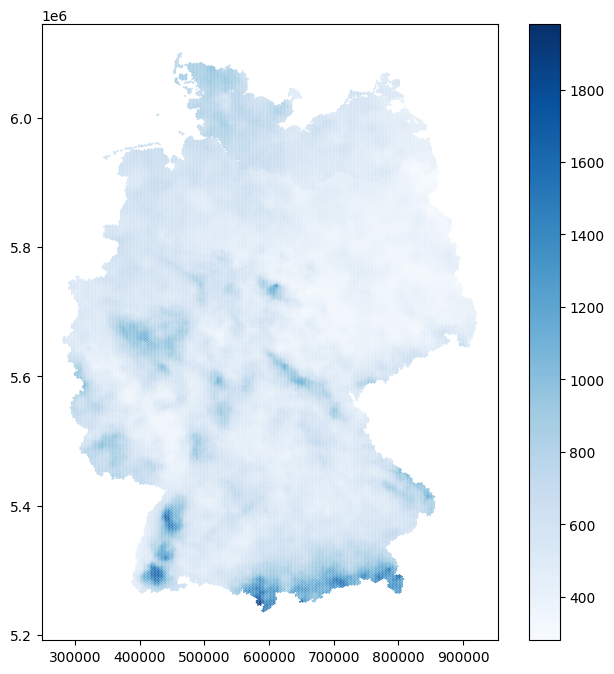

In [39]:
FINAL_OUT_DIR = os.path.join(PROJECT_DATA_DIR, 'OUTPUT', f'Landscape_Metrics_{DISTANCE}KM')
final_df = pd.read_csv(os.path.join(FINAL_OUT_DIR, f'{CROP.lower()}_climate.csv'))
test = final_df[(final_df['year']==2020)]
test_gdf = pd.merge(left=grids_gdf, right=test, on=['id'], how='left')
test_gdf.plot(column='Prcp_Sum', legend=True, figsize=(8, 8), cmap='Blues');
print(test_gdf.shape)
test_gdf.head()

In [54]:
test_gdf

,id,geometry,NUTS_NAME,year,Prcp_Max,Prcp_Sum,Prcp_Var_Index,Tmin_Min,Tmin_Mean,Tmin_Std,Tmax_Max,Tmax_Mean,Tmax_Std,Rad_Min,Rad_Max,Rad_Mean,Rad_Std
0,68921,"POLYGON ((709129.96 5565059.119, 709851.648 55...",Bayern,2020.0,19.050000,534.266667,0.999648,-7.683333,3.249444,5.274861,32.216667,11.976167,7.640567,1.637333,30.106500,10.775365,8.508767
1,68920,"POLYGON ((709129.96 5567559.119, 709851.648 55...",Bayern,2020.0,19.760000,530.060000,0.988432,-7.680000,3.378200,5.268334,32.360000,12.118467,7.641532,1.638800,30.121400,10.769792,8.509092
2,68923,"POLYGON ((709129.96 5560059.119, 709851.648 55...",Bayern,2020.0,20.150000,605.350000,0.971654,-7.833333,2.983167,5.304599,31.800000,11.543667,7.621521,1.629500,30.143000,10.779231,8.348533
3,68922,"POLYGON ((709129.96 5562559.119, 709851.648 55...",Bayern,2020.0,19.340000,570.960000,1.002437,-7.760000,2.963267,5.307858,31.660000,11.501600,7.596559,1.644200,30.159600,10.828673,8.517516
4,68925,"POLYGON ((709129.96 5555059.119, 709851.648 55...",Bayern,2020.0,22.483333,644.766667,0.949325,-7.766667,3.047278,5.350333,31.950000,11.489000,7.666234,1.623167,30.066667,10.748715,8.382589
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67540,69092,"POLYGON ((711295.023 6003809.119, 712016.711 6...",Mecklenburg-Vorpommern,2020.0,43.183333,564.683333,0.827874,-3.266667,5.388422,4.810273,28.833333,12.722430,6.113276,1.222167,30.997167,10.699483,8.752885
67541,69095,"POLYGON ((711295.023 5996309.119, 712016.711 5...",Mecklenburg-Vorpommern,2020.0,47.583333,559.866667,0.838228,-3.933333,4.667653,4.752390,28.966667,12.582035,6.223808,1.230500,30.440500,10.608822,8.632786
67542,69094,"POLYGON ((711295.023 5998809.119, 712016.711 6...",Mecklenburg-Vorpommern,2020.0,47.000000,560.200000,0.831600,-3.783333,4.825701,4.768930,28.983333,12.650000,6.205861,1.227500,30.610833,10.631400,8.669605
67543,69087,"POLYGON ((711295.023 6016309.119, 712016.711 6...",Mecklenburg-Vorpommern,2020.0,64.033333,588.250000,0.760576,-2.916667,5.945587,4.479373,29.400000,12.858983,6.051772,1.206500,33.367833,11.265293,9.398200


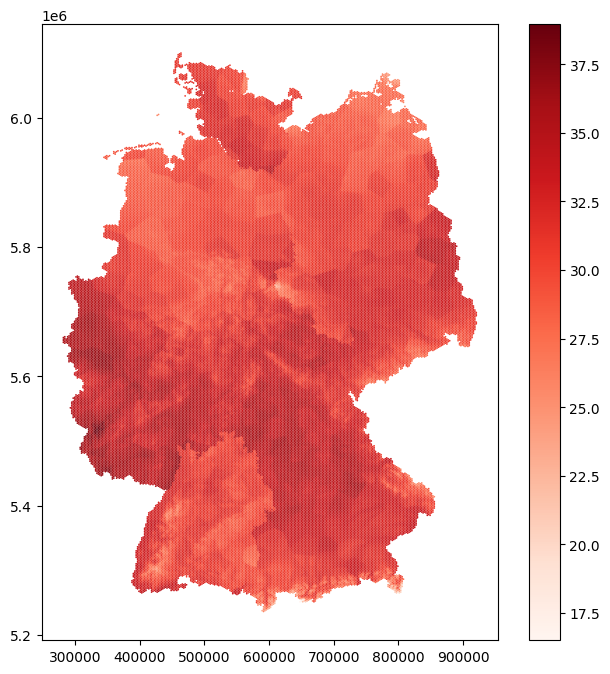

In [56]:
test_gdf.plot(column='Tmax_Max', legend=True, figsize=(8, 8), cmap='Reds');